In [23]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import cv2
from matplotlib import pyplot as plt

from google.colab import drive
import sys

In [24]:
# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Cargar bases de datos procesadas
x_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_test.pkl')

In [26]:
# Ver las formas (número de imágenes, alto, ancho, canales, etc.)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (5712, 198, 150, 3)
y_train shape: (5712, 1)
x_test shape: (1311, 198, 150, 3)
y_test shape: (1311, 1)


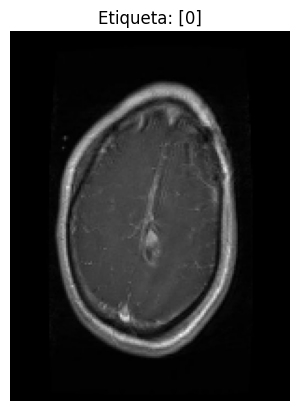

In [27]:
# Mostrar la imagen
plt.imshow(x_train[999])
plt.title(f"Etiqueta: {y_train[999]}")
plt.axis('off')
plt.show()

In [19]:
# # Celda 1: Conversión a float32 para escalar
# x_train = x_train.astype('float32')  # para poder escalarlo
# x_test = x_test.astype('float32')    # para poder escalarlo

# # Celda 2: Escalado entre 0 y 1
# x_train /= 255
# x_test /= 255

# # Celda 3: Mostrar formas de los datos
# print("Shape x_train:", x_train.shape)
# print("Shape x_test:", x_test.shape)

# # Celda 4: Cantidad de variables por imagen (producto de dimensiones)
# print("Variables por imagen (x_train[1]):", np.prod(x_train[1].shape))

# # Celda 5: Conteo de etiquetas únicas
# print("Distribución y_train:", np.unique(y_train, return_counts=True))
# print("Distribución y_test:", np.unique(y_test, return_counts=True))

# # Celda 6: Formas de las etiquetas
# print("Shape y_train:", y_train.shape)
# print("Shape y_test:", y_test.shape)

# # Celda 7: Reestructurar arrays de imágenes a 1D (reshape)
# # x_train2 = x_train.reshape(5712, 89100)
# # x_test2 = x_test.reshape(1311, 89100)

# x_train2 = x_train.reshape(x_train.shape[0], -1)
# x_test2 = x_test.reshape(x_test.shape[0], -1)

# print("Shape x_train2:", x_train2.shape)
# print("Shape x_test2:", x_test2.shape)

# # Celda 8: Mostrar la primera imagen del conjunto reestructurado
# print("Primera imagen reestructurada (x_train2[1]):", x_train2[1])

Shape x_train: (5712, 198, 150, 3)
Shape x_test: (1311, 198, 150, 3)
Variables por imagen (x_train[1]): 89100
Distribución y_train: (array([0, 1, 2, 3]), array([1321, 1339, 1457, 1595]))
Distribución y_test: (array([0, 1, 2, 3]), array([300, 306, 300, 405]))
Shape y_train: (5712, 1)
Shape y_test: (1311, 1)
Shape x_train2: (5712, 89100)
Shape x_test2: (1311, 89100)
Primera imagen reestructurada (x_train2[1]): [0. 0. 0. ... 0. 0. 0.]


In [35]:
##### convertir a 1 d array ############

x_train2 = x_train.reshape(x_train.shape[0], -1)
x_test2 = x_test.reshape(x_test.shape[0], -1)

x_train2.shape
x_test2.shape

x_train2[1]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

<ipython-input-34-741af3695b3b>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Etiqueta: {int(y_train[1])}")


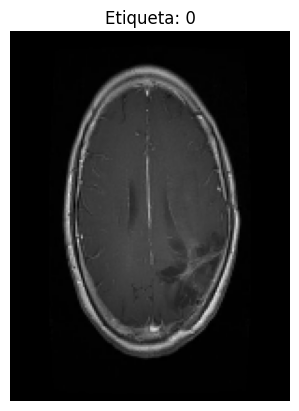

In [34]:
# # Reconstruir la forma original (198 alto, 150 ancho, 3 canales)
# img = x_train2[1].reshape((198, 150, 3))

# # Mostrar la imagen
# plt.imshow(img)
# plt.title(f"Etiqueta: {int(y_train[1])}")
# plt.axis('off')
# plt.show()

In [ ]:
############################################################
###############Seleccionar un indicador ################
############################################################

### Precision Tasa de acierto en predichos positivos ( qué porcentaje de personas identificada con neumonía realmente tienen)
### Recall: Tasa de identficación de positivos (de los que tenían neumonía cuantos predije tenían)
### F1_Socre: Combina Precions y recall (promedio entre dos anteriores)
### Acurracy: Porcentaje de acertados
### AUC: detección de positivos vs mala clasificaicón de negativos: porcentaje de los que neumonía que identifico vs los normales que digo que tiene neumonía

############Analisis problema ###########
#### me interesa recall: de los enfermos que los pueda detectar, sin embargo
#### el problema es que puede generar mucho trabajo porque clasifica a
####la mayoria como con neumonía, entonces usaremos el AUC que mide la capacidad e clasificación de neumoinía en balance con los noramles mal calsificados

In [38]:
################ Preprocesamiento  para modelos Shallow learning##############
### REGRESIÓN LOGÍSTICA ###

# Asegurar que las etiquetas tengan forma correcta
y_train = y_train.ravel()
y_test = y_test.ravel()

# OPCIÓN 1: Eliminar parámetro deprecated
lr = LogisticRegression(max_iter=1000, solver='lbfgs')
# OPCIÓN 2: Usar OneVsRestClassifier
# lr = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='lbfgs'))

lr.fit(x_train2, y_train)

# Clases predichas
pred_train_lr = lr.predict(x_train2)
print("Entrenamiento:")
print(metrics.classification_report(y_train, pred_train_lr, zero_division=0))

# AUC requiere probabilidades
probs_train_lr = lr.predict_proba(x_train2)
print("AUC train:", metrics.roc_auc_score(y_train, probs_train_lr, multi_class='ovr', average='macro'))

# Clases predichas en test
pred_test_lr = lr.predict(x_test2)
print("Test:")
print(metrics.classification_report(y_test, pred_test_lr, zero_division=0))

# AUC en test
probs_test_lr = lr.predict_proba(x_test2)
print("AUC test:", metrics.roc_auc_score(y_test, probs_test_lr, multi_class='ovr', average='macro'))

### REGRESIÓN LOGÍSTICA ###
Entrenamiento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1595

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712

AUC train: 1.0
Test:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       300
           1       0.74      0.79      0.76       306
           2       0.93      0.92      0.92       300
           3       0.95      0.99      0.97       405

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.86      0.86      0.86      1311

AUC test: 0.9626358969000741


In [40]:
############################################################
################ Probar modelos de tradicionales#########
############################################################

#################### RandomForest ##########



rf = RandomForestClassifier()
rf.fit(x_train2, y_train)

# Predicciones para train
pred_train = rf.predict(x_train2)
print(metrics.classification_report(y_train, pred_train))

# Probabilidades para train (todas las clases)
pred_train_proba = rf.predict_proba(x_train2)
roc_auc_train = metrics.roc_auc_score(y_train, pred_train_proba, multi_class='ovr')
print("ROC AUC train:", roc_auc_train)

# Predicciones para test
pred_test = rf.predict(x_test2)
print(metrics.classification_report(y_test, pred_test))

# Probabilidades para test (todas las clases)
pred_test_proba = rf.predict_proba(x_test2)
roc_auc_test = metrics.roc_auc_score(y_test, pred_test_proba, multi_class='ovr')
print("ROC AUC test:", roc_auc_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1595

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712

ROC AUC train: 1.0
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       300
           1       0.86      0.92      0.89       306
           2       0.94      0.98      0.96       300
           3       0.98      1.00      0.99       405

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311

ROC AUC test: 0.9917489266423752
